In [1]:
# Add the root path of the pyqula library
import os ; import sys
try: sys.path.append(os.environ["PYQULAROOT"]) # add the library via environmental variable
except: 
    try: from pyqula import geometry # check if the library is present
    except: print("Install pyqula with\npip install --upgrade pyqula") # pyqula must be installed

# some default parameters in matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'

# parallelization
# from pyqula import parallel ; parallel.set_cores("max") # uncomment to use all the cores

import numpy as np

# Superconductivity in 2D materials
In this session we will address several different examples involving superconductivity
### Contents
- Superconductivity driven by interactions
- Impact of spin-orbit coupling in superconductivity
- Impact of magnetism in superconductivity
- Artificial topological superconductivity

### Learning outcomes
- Understand which interactions promote superconductivity, and how the electronic structure gets modified
- Understand which perturbations are detrimental to superconductivity
- Understand how unconventional superconductors can be engineered in 2D materials

### The impact of superconductivity in an electronic structure
Let us first show how a superconducting order affects an electronic structure. For this, let us change the chemical potential of a lattice, and include spin-singlet superconductivity in the different cases

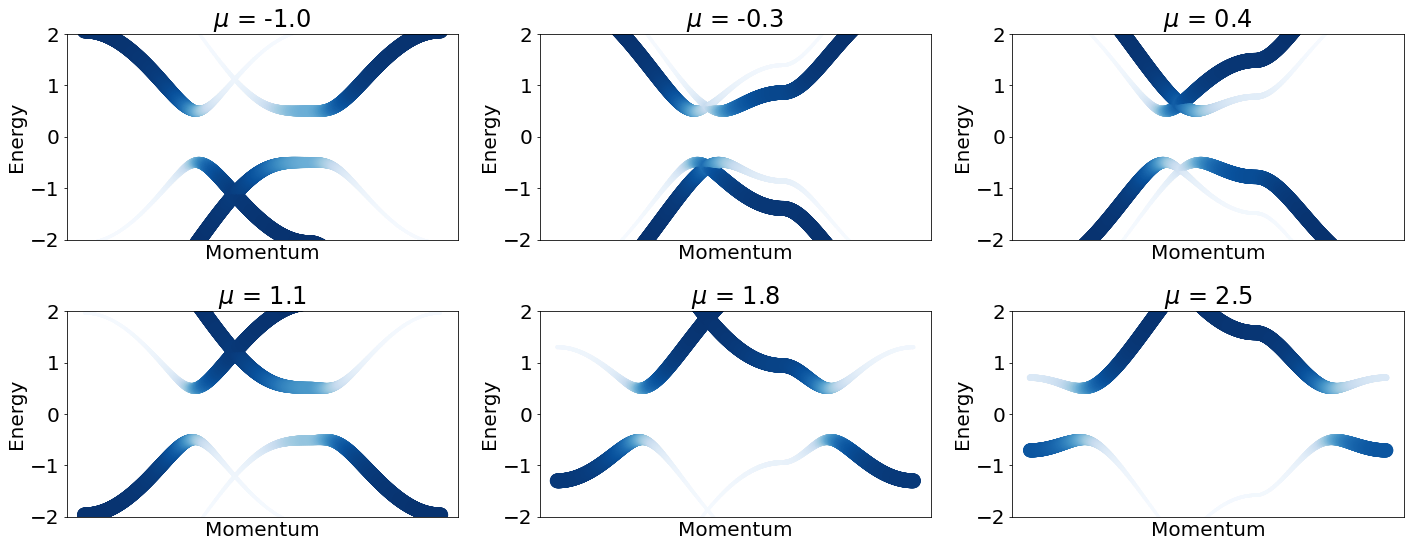

In [2]:
from pyqula import geometry
mus = np.linspace(-1.,2.5,6) # chemical potentials
g = geometry.honeycomb_lattice() # take a triangular lattice
iw = 1 # counter
delta = 0.5 # value of the superconducting order
for mu in mus: # loop over local potentials
    h = g.get_hamiltonian() # generate Hamiltonian
    h.add_onsite(mu) # shift chemical potential
    h.add_swave(delta) # add superconductivity 
    plt.subplot(2,len(mus)//2,iw) 
    iw +=1 ; plt.title("$\mu$ = "+str(np.round(mu,3)))
    (k,e,c) = h.get_bands(operator="electron",kpath=["G","K","M","G"]) # compute band structure
    plt.scatter(k,e,c=c,s=200*c,cmap="Blues") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
    plt.xticks([]) ; plt.ylim([-2.,2.]) # plot
plt.tight_layout() # adjust

### Exercise
- Switch off the superconducting order. Do you still see a gap at the different chemical potentials?
- Does the gap depend on the chemical potential for finite superconducting order?
- Replace the honeycomb lattice by any other type of lattice. Do you still see a gap opening for different chemical potentials?

## s-wave superconductivity driven by attractive interactions
First, we will show how a superconducting state appears due to attractive interactions

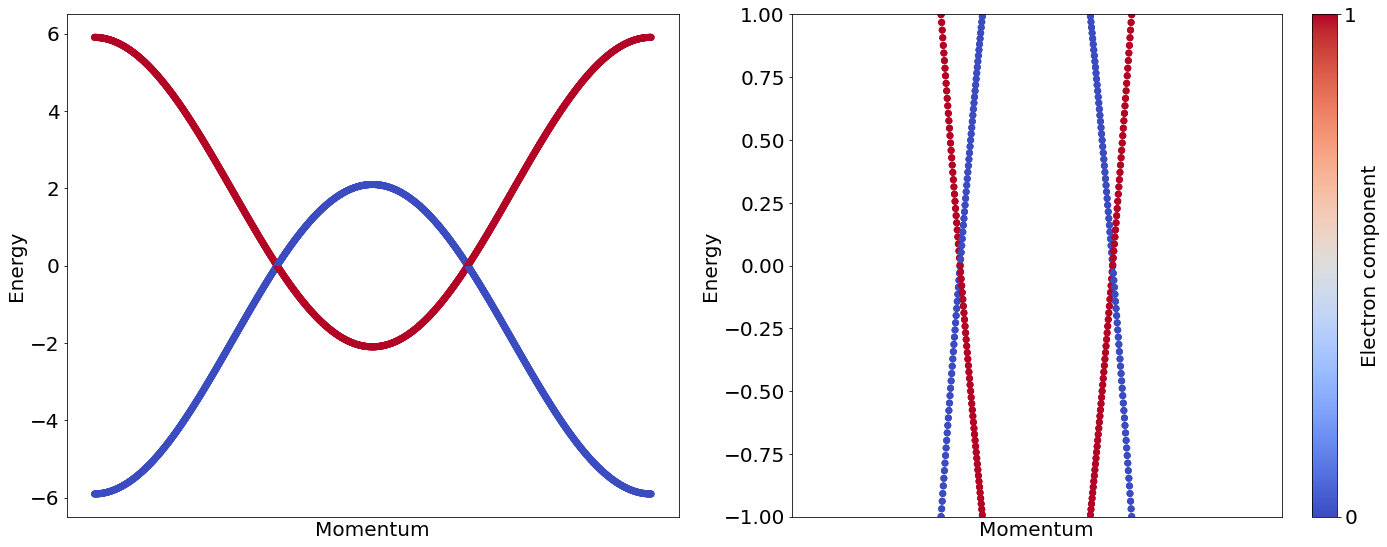

In [4]:
from pyqula import geometry
# as a warm up, let us look at how the bands look like if we added a Nambu spinor
# first, let us see how the band structure looks like
g = geometry.square_lattice() # generate a square lattice
h = g.get_hamiltonian() # generate the Hamiltonian
h.set_filling(0.2,nk=20) # set filling
h.setup_nambu_spinor() # setup the nambu spinor
(k,e,c) = h.get_bands(operator="electron",nk=800) # compute band structure, returning the electron-hole flavor

# plot the bands in a wide and narrow range
plt.subplot(1,2,1)
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot
plt.subplot(1,2,2)
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ;plt.ylim([-1,1]) # plot
plt.colorbar(label="Electron component",ticks=[0.,1.])

plt.tight_layout()

### Exercise
- Discuss how the bands with a Nmabu spinor can be understood in terms of the bands without a Nambu spinor

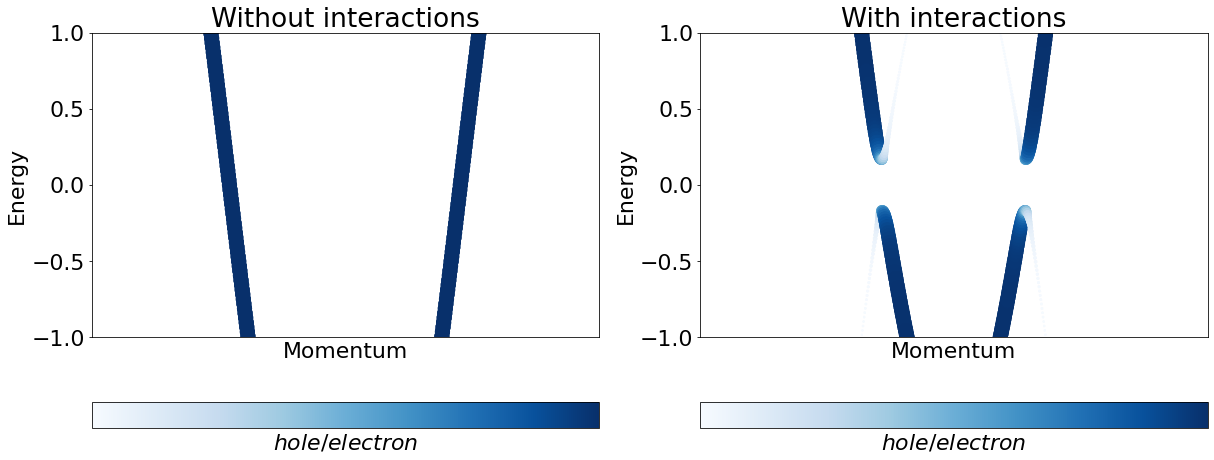

In [30]:
from pyqula import geometry
# now, let us include attractive interactions at the mean-field level
g = geometry.square_lattice() # generate a square lattice
h = g.get_hamiltonian() # generate the Hamiltonian
h.setup_nambu_spinor() # setup the nambu spinor

def plot_case(hscf):
    (k,e,c) = hscf.get_bands(operator="electron",nk=800) # compute band structure
    plt.scatter(k,e,c=c,s=200*c,cmap="Blues") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
    plt.xticks([]) ; plt.ylim([-1,1]) ; plt.colorbar(label="$hole/electron$",ticks=[],orientation="horizontal")

# first, let us see how the band structure looks like without interactions
plt.subplot(1,2,1) ; plt.title("Without interactions")
plot_case(h)

# now, let us see how the band structure looks like with interactions
hscf = h.get_mean_field_hamiltonian(U=-2.0,filling=0.2,nk=10,mix=0.9,mf="swave")
plt.subplot(1,2,2) ; plt.title("With interactions")
plot_case(hscf)



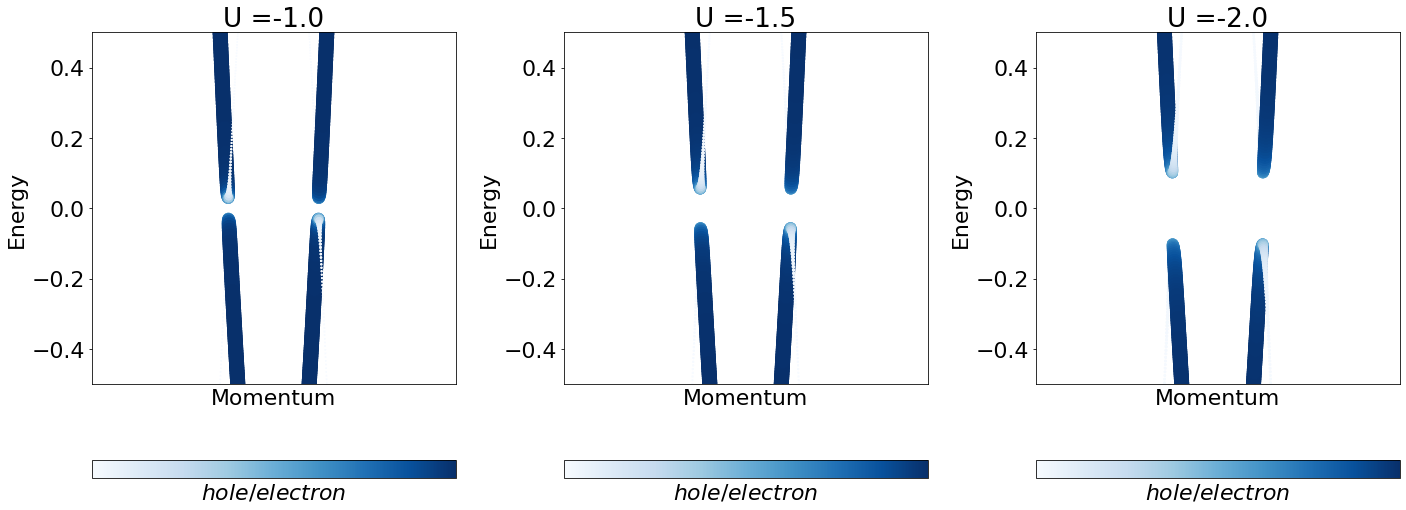

In [29]:
from pyqula import geometry
# We now compare the band structure for different interaction strength
g = geometry.square_lattice() # generate a square lattice
h = g.get_hamiltonian() # generate the Hamiltonian
h.setup_nambu_spinor() # setup the nambu spinor
Us = [-1.0,-1.5,-2.0]
iu = 0
# h.add_exchange([0.,0.,0.1]) # to add a Zeeman field
for U in Us: # loop over interaction strength
    hscf = h.get_mean_field_hamiltonian(U=U,filling=0.1,nk=10,mix=0.9,mf="swave")
    # first, let us see how the band structure looks like
    (k,e,c) = hscf.get_bands(operator="electron",nk=2000) # compute band structure
    plt.subplot(1,len(Us),iu+1) ; iu += 1
    plt.scatter(k,e,c=c,s=200*c,cmap="Blues") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
    plt.xticks([]) ; plt.ylim([-.5,.5]) ; plt.title("U ="+str(U)) 
    plt.colorbar(label="$hole/electron$",ticks=[],orientation="horizontal")
    
plt.tight_layout()

### Exercise
- Perform the selfconsistent calculation above including an external Zeeman field. Does the superconducting gap become bigger or smaller? This effect is known as paramagnetic depairing.

## Unconventional singlet superconducting orders
In the example above we considered the simplest superconducting case, an s-wave superconductor. Let us now address other types of superconducting order parameters

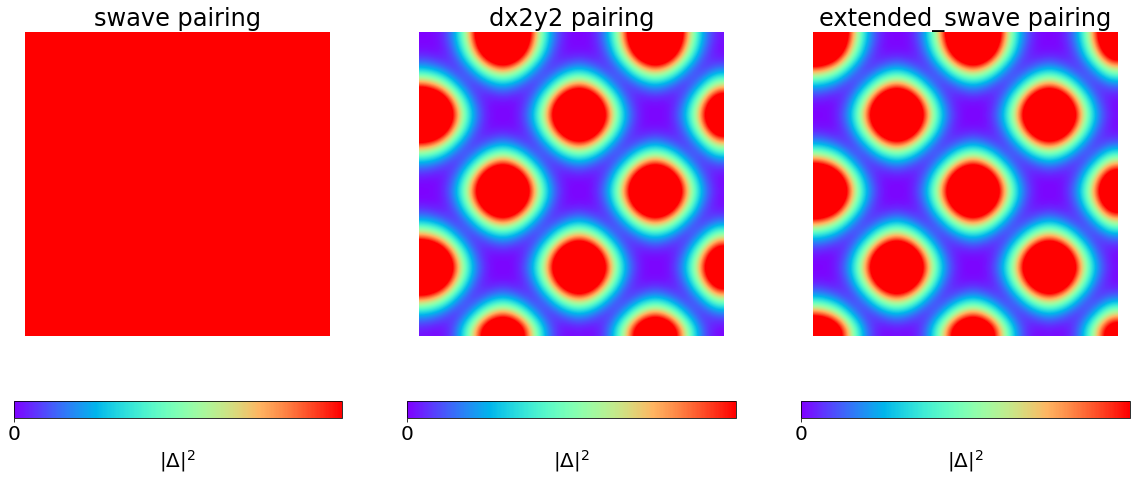

In [7]:
from pyqula import geometry
g = geometry.square_lattice() # generate a square lattice

# define a function to return pairing in reciprocal space
def deltak(mode): # function to extract the pairing from a geometry
    h = g.get_hamiltonian() # generate Hamiltonian
    h.add_pairing(mode=mode,delta=0.2) # extract the spin-singlet component in reciprocal space
    nk = 20 # number of k-points
    (kx,ky,ds) = h.extract("deltak",nk=nk,mode="all") # extract pairing in reciprocal space
    ds = ds.reshape((nk,nk)).real # real part
    ds = ds/np.max(np.abs(ds)) # normalize 
    plt.imshow(ds,vmin=0.,vmax=.5,interpolation='bicubic',cmap="rainbow") ; plt.axis("equal") ; plt.axis("off") 
    plt.colorbar(ticks=[0,1],label="$|\Delta|^2$",orientation = 'horizontal')
    plt.title(mode+" pairing")


ps = ["swave","dx2y2","extended_swave"]
ip = 1
for p in ps: # plot all the pairings
    plt.subplot(1,len(ps),ip) ; ip+=1 
    deltak(p)


### Exercise
- Replace the square lattice by a triangular lattice. Which of the orders above break the symmetry of the lattice?
- Discuss how you can see from the plots above that those pairings correspond to a spin singlet state from symmetry considerations
- (Advanced) Does the extended s-wave order lead to a fully gapped superconductor?

## Gapped and nodal superconducting orders
Let us now discuss different superconducting orders in the triangular lattice, in particular focusing on gaped s-wave order and nodal f-wave order

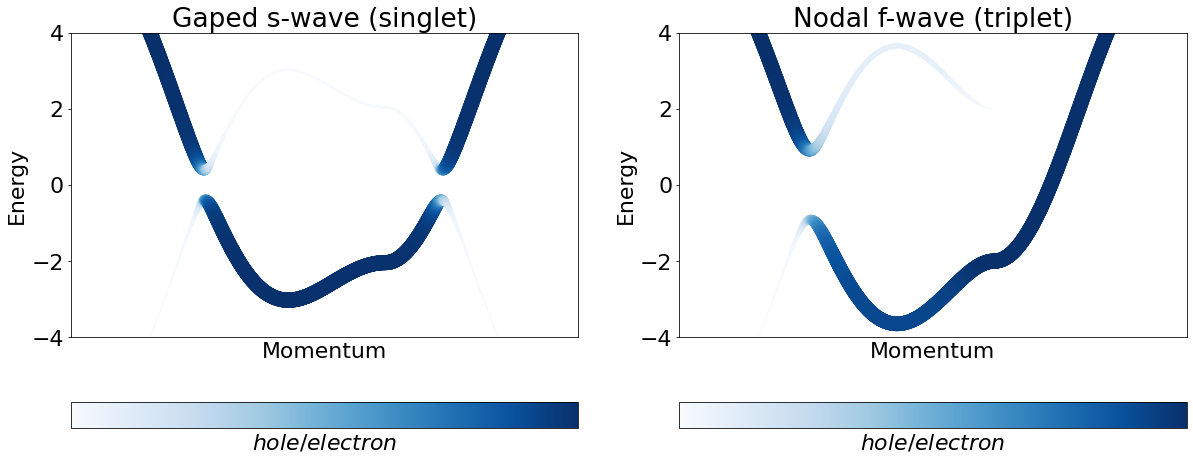

In [31]:
from pyqula import geometry
g = geometry.triangular_lattice() # generate a triangular lattice

# first s-wave
plt.subplot(1,2,1) ;  plt.title("Gaped s-wave (singlet)")
h = g.get_hamiltonian() # generate Hamiltonian
h.add_pairing(mode="swave",delta=0.4) # add swave pairing
(k,e,c) = h.get_bands(operator="electron",kpath=["G","K","M","G"]) # compute bands
plt.scatter(k,e,c=c,s=200*c,cmap="Blues") ; plt.xlabel("Momentum") 
plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-4,4]) # plot
plt.colorbar(label="$hole/electron$",ticks=[],orientation="horizontal")

# now nodal f-wave
plt.subplot(1,2,2) ;  plt.title("Nodal f-wave (triplet)")
h = g.get_hamiltonian() # generate Hamiltonian
h.add_pairing(mode="nodal_fwave",delta=0.2) # add swave pairing
(k,e,c) = h.get_bands(operator="electron",kpath=["G","K","M","G"]) # compute bands
plt.scatter(k,e,c=c,s=200*c,cmap="Blues") ; plt.xlabel("Momentum") 
plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-4,4]) # plot
plt.colorbar(label="$hole/electron$",ticks=[],orientation="horizontal")


### Exercise
- Discuss why an f-wave order is a triplet superconducting order parameter
- Discuss in which points of the Brillouin zone the triplet order (odd order parameter) must have nodes

## s-wave superconductivity in the presence of spin-orbit coupling
In the following we will show how a superconducting state is compatible with spin-orbit coupling. As a reference, we will use the Hamiltonian of NbSe2 that includes long range hopping.

### Ising spin-orbit coupling
Here we first start looking at the impact of Ising spin-orbit coupling, and its interplay with superconductivity. In the presence of s-wave superconductivity, spin-orbit coupling is not detrimental to the superconducting state

([], [])

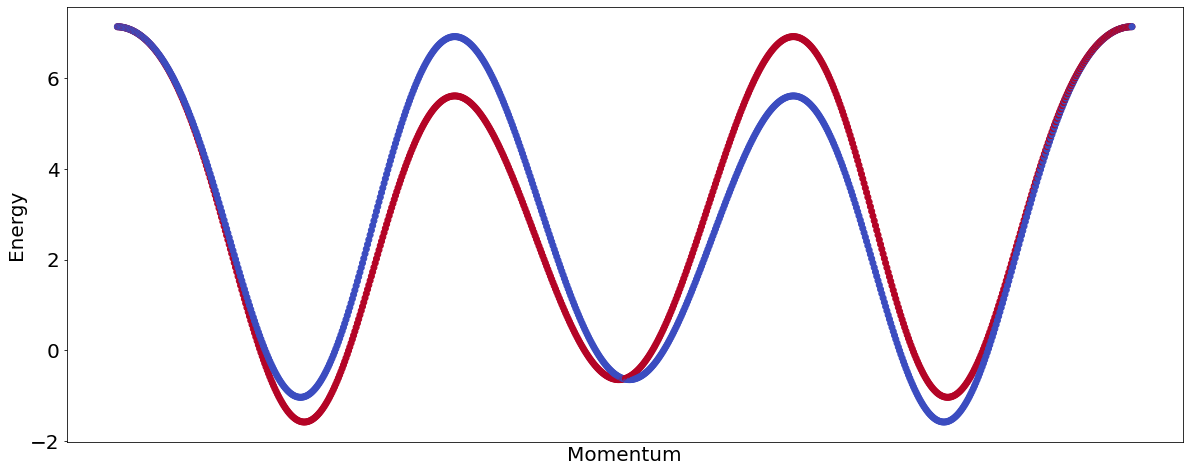

In [9]:
# first compute the bands without superconductivity
from pyqula import specialhamiltonian # special Hamiltonians library
h = specialhamiltonian.NbSe2(soc=0.5) # NbSe2 Hamiltonian
(k,e,c) = h.get_bands(operator="sz",nk=800) # compute bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

(-2.0, 2.0)

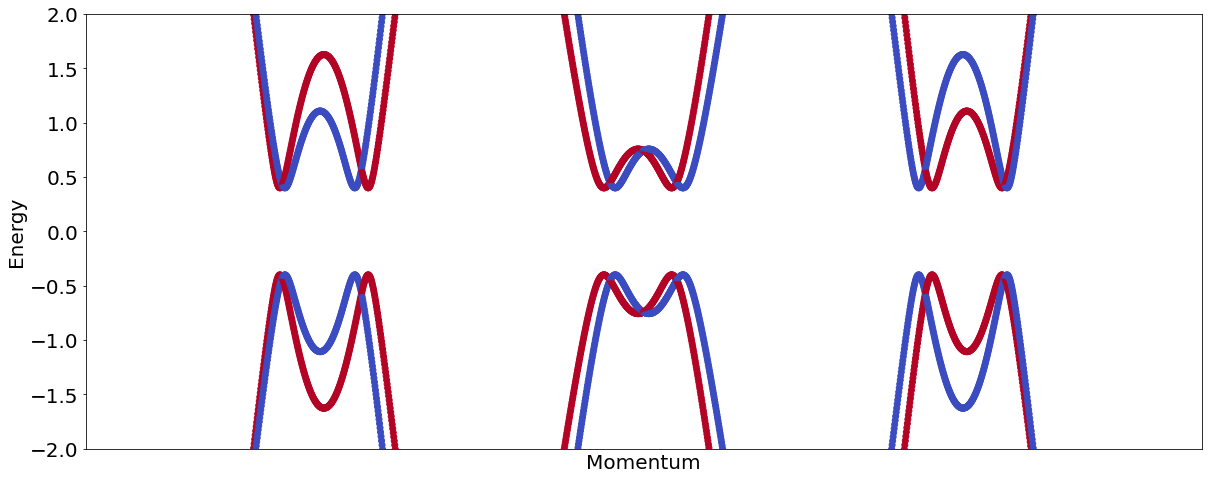

In [10]:
# now add superconductivity
from pyqula import specialhamiltonian # special Hamiltonians library
h = specialhamiltonian.NbSe2(soc=0.5) # NbSe2 Hamiltonian
h.add_swave(0.4)
(k,e,c) = h.get_bands(operator="sz",nk=2000) # compute bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-2,2]) # plot

### Exercise
- Increase the value of the spin-orbit coupling. Does the superconducting gap in the band structure change?
- Discuss why you observe the phenomenology above

## Rashba spin-orbit coupling
Here we look at the impact of Rashba spin-orbit coupling, and its interplay with s-wave superconductivity. Due to Kramer's theorem, a finite Rashba spin-orbit coupling is not detrimental for an s-wave superconducting state

([], [])

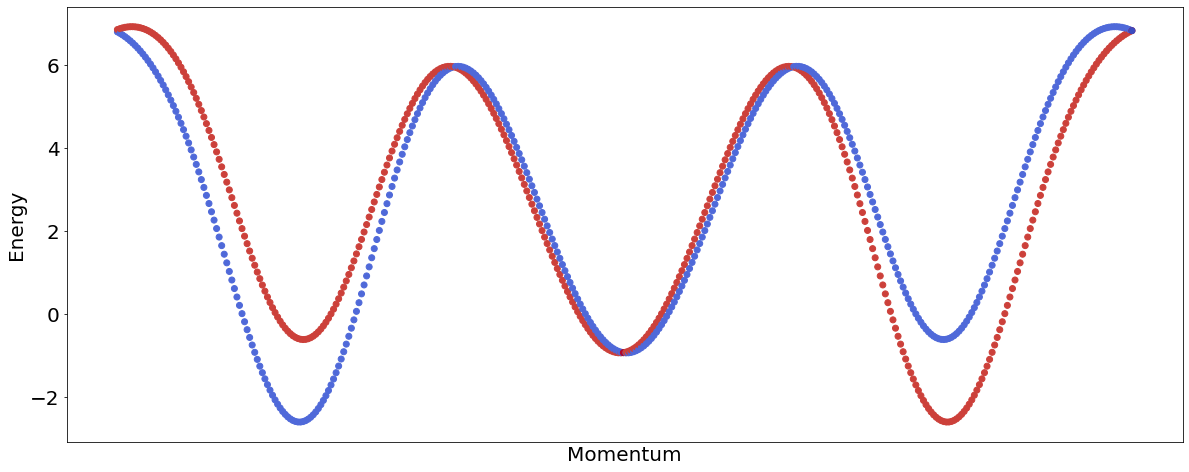

In [11]:
# first compute the bands without superconductivity
from pyqula import specialhamiltonian # special Hamiltonians library
h = specialhamiltonian.NbSe2() # NbSe2 Hamiltoni|an
h.add_rashba(0.3) # add Rashba SOC
(k,e,c) = h.get_bands(operator="sx") # compute bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

(-2.0, 2.0)

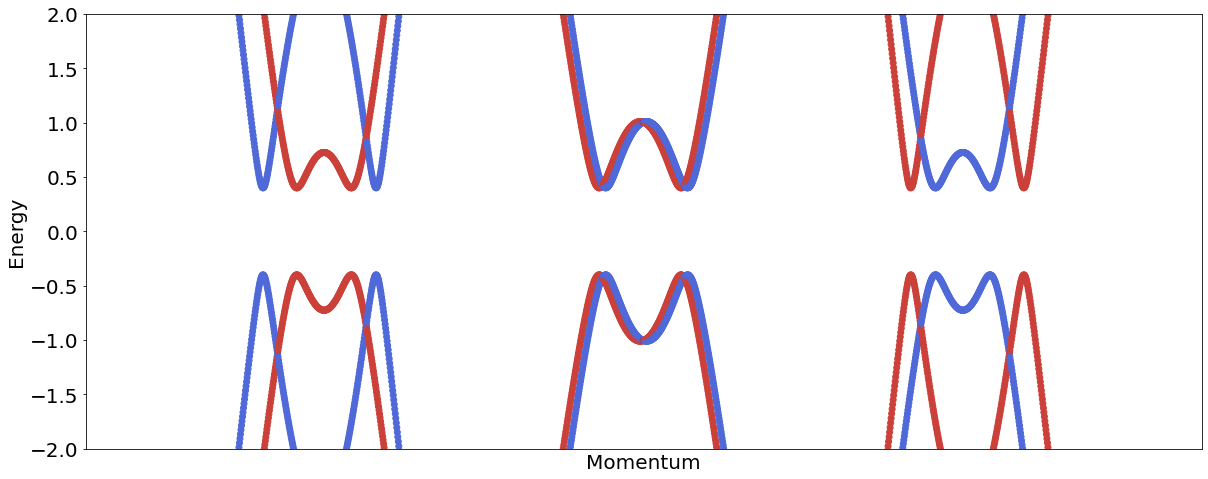

In [12]:
# now also add superconductivity
from pyqula import specialhamiltonian # special Hamiltonians library
h = specialhamiltonian.NbSe2() # NbSe2 Hamiltonian
h.add_rashba(0.3) # add Rashba SOC
h.add_swave(0.4)
(k,e,c) = h.get_bands(operator="sx",nk=2000) # compute bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-2,2]) # plot

### Exercise
- Compute the electronic structure with s-wave superconductivity in the presence of both Rashba and Ising spin-orbit coupling, and show that the superconducting gap remains unaffected in the presence of SOC.
- Discuss why the phenomenology above happens.

## s-wave superconductivity in the presence of magnetism
Let us now see how the presence of magnetism impacts an s-wave superconducting state

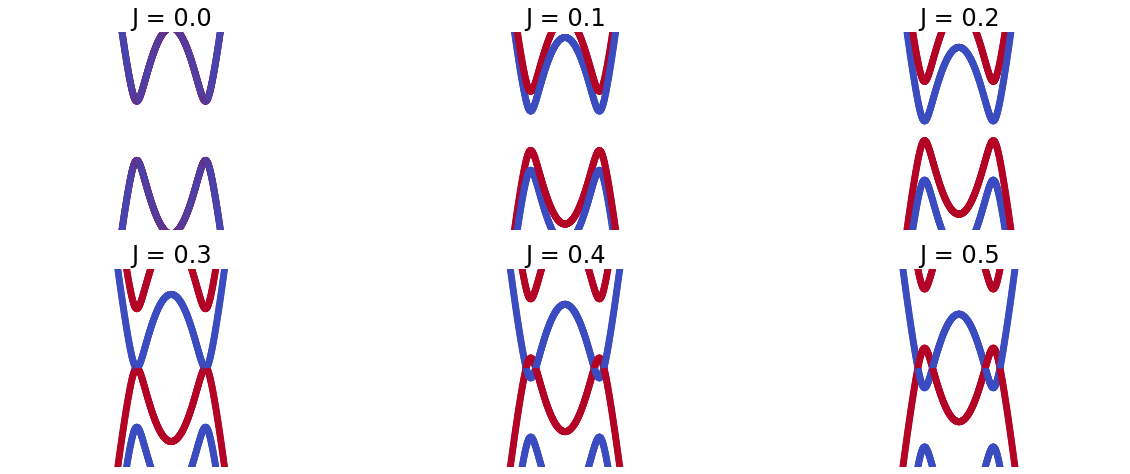

In [13]:
# plot the bands for different exchance couplings
from pyqula import geometry
Js = np.linspace(0.,0.5,6) # exchange couplings
ij = 0 # counter
for J in Js: # loop over exchange couplings
    g = geometry.square_lattice() # get the geometry
    h = g.get_hamiltonian() # get the Hamiltonian
    h.add_onsite(3.) # shift chemical potential
    h.add_zeeman([0.,0.,J]) # add exchange field
    h.add_swave(0.3) # add swave SC
    (k,e,c) = h.get_bands(nk=1000,operator="sz") # compute the bands
    plt.subplot(len(Js)//3,3,ij+1) ; ij +=1 
    plt.scatter(k,e,c=c) ; plt.axis("off") ; plt.ylim([-1.,1.]) ; plt.title("J = "+str(round(J,2))) # plot

### Exercise
- Change the value of the superconducting term. At which value of the exchange do you see the gap closing?
- Discuss why a magnetic exchange field closes the gap 

## Yu-Shiba-Rusinov states in s-wave superconductors
Let now show how a local magnetic impurity gives rise to in-gap modes in a superconductor

(-2.0, 2.0)

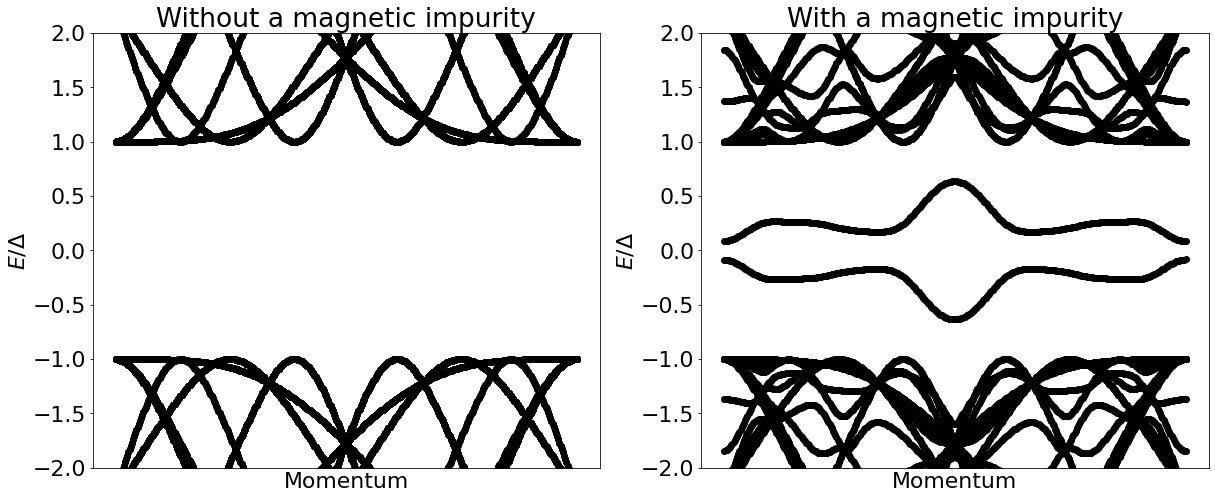

In [28]:
from pyqula import geometry, potentials # to put an impurity
g = geometry.triangular_lattice() # take a triangular lattice
g = g.get_supercell((6,6)) # make a supercell so that we have many sites per unit cell
h = g.get_hamiltonian() # generate Hamiltonian

delta = 0.5 # superconducting order parameter
h.add_swave(delta) # add superconductivity

# first without the impurity
plt.subplot(1,2,1) ; plt.title("Without a magnetic impurity")
(k,e) = h.get_bands() # compute bands
plt.scatter(k,e/delta,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("$E/\Delta$") 
plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

# now with the magnetic impurity
plt.subplot(1,2,2) ; plt.title("With a magnetic impurity")
fimp = potentials.impurity(g.r[0],v=[0.,0.,2.]) # magnetic impurity
h.add_exchange(fimp) # add local magnetic impurity
(k,e) = h.get_bands() # compute bands
plt.scatter(k,e/delta,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("$E/\Delta$") 
plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

### Exercise
- Change the strength of the magnetic impurity. How does the in-gap band change?
- Replace the magnetic impurity by a local non-magnetic potential (add_onsite). Discuss why the result is different from the magnetic impurity

#### In the lab
- Yu-Shiba-Rusinov states can be engineered by depositing individual magnetic atoms in NbSe2
https://pubs.acs.org/doi/full/10.1021/acs.nanolett.9b03988

## Single magnetic impurity in a superconductor
ABove we considered a periodic lattice of magnetic impurities, now we will consider a single magnetic site in an infinite system

(0.0, 4.146764000529834)

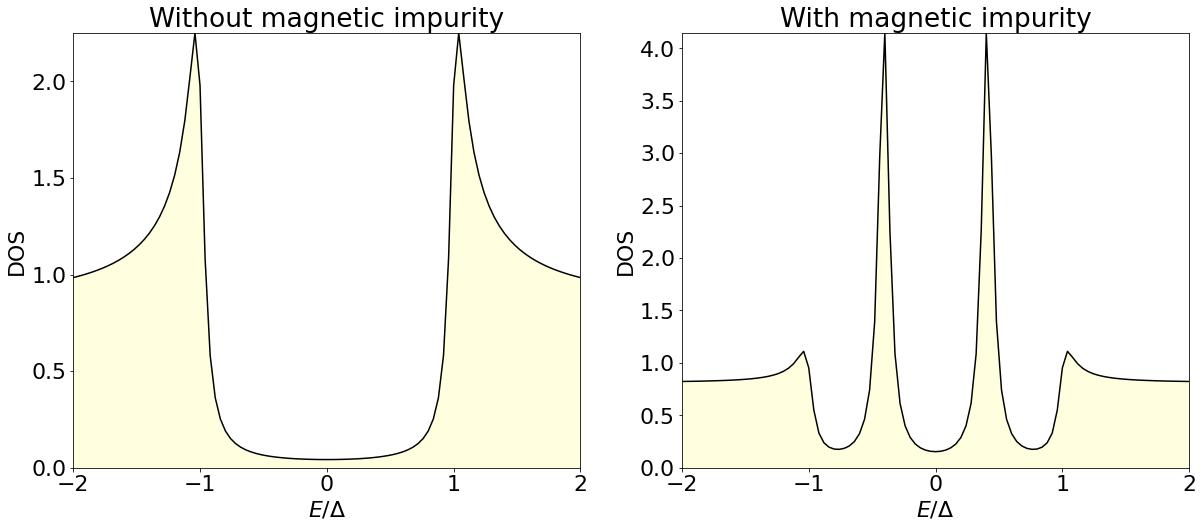

In [16]:
from pyqula import geometry, potentials, embedding
g = geometry.triangular_lattice() # take a triangular lattice
g = g.get_supercell((2,2)) # make a supercell so that we have several sites per unit cell
h = g.get_hamiltonian() # generate Hamiltonian
h.add_onsite(-4.0) # shift the chemical potential
delta = 1e-3 # superconducting order parameter (very small to have nearly constant DOS in the energy window)
h.add_swave(delta) # add superconductivity 
hv = h.copy() # make a copy
hv.add_zeeman(potentials.impurity(g.r[0],v=[0.,0.,3.])) # unit cell with a magnetic impurity

# first the pristine
plt.subplot(1,2,1) ; plt.title("Without magnetic impurity")
eb = embedding.Embedding(h,m=h) 
energies = np.linspace(-2*delta,2*delta,101) # energy grid
(e,d) = eb.multidos(es=energies,delta=delta/20) # compute DOS
e = e/delta # redefine
plt.plot(e,d,c="black") ; plt.xlabel("$E/\Delta$") ; plt.ylabel("DOS") # plot
plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
plt.xlim([min(e),max(e)]) ; plt.ylim([0,max(d)])

# create an embedding object (infinite pristine system with h, central impurity hv)
plt.subplot(1,2,2) ; plt.title("With magnetic impurity")
eb = embedding.Embedding(h,m=hv) 
(e,d) = eb.multidos(es=energies,delta=delta/20) # compute LDOS
e = e/delta # redefine
plt.plot(e,d,c="black") ; plt.xlabel("$E/\Delta$") ; plt.ylabel("DOS") # plot
plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
plt.xlim([min(e),max(e)]) ; plt.ylim([0,max(d)])

### Exercise
- Change the value of the exchange coupling. How does the in-gap state depend on the exchange?
- Make the superconducting order twice as big. Does the relative position of the in-gap state change?

## Electron-hole asymmetry in Yu-Shiba-Rusinov states
Let us now see how an non-magnetic potential gives rise to electron-hole asymmetry in Yu-Shiba-Rusinov states

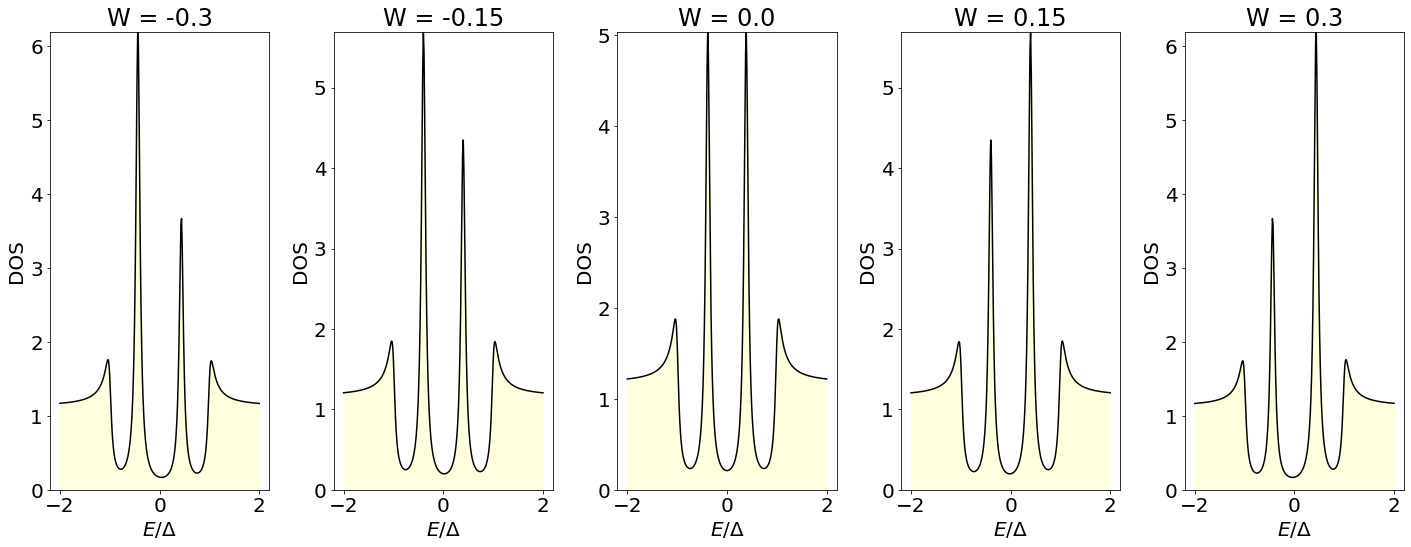

In [16]:
from pyqula import geometry, potentials, embedding
g = geometry.chain() # take a chain to make the calculations faster
g = g.get_supercell(3) # make a supercell so that we have several sites per unit cell
delta = 1e-3 # superconducting order parameter (very small to have nearly constant DOS in the energy window)
h = g.get_hamiltonian() # generate Hamiltonian
h.add_swave(delta) # add superconductivity 
energies = np.linspace(-2*delta,2*delta,301) # energy grid
Ws = np.linspace(-0.3,0.3,5) # potentials
iw = 1 # counter
for W in Ws: # loop over local potentials
    hv = h.copy() # make a copy
    hv.add_zeeman(potentials.impurity(g.r[1],v=[0.,0.,3.])) # magnetic impurity
    hv.add_onsite(potentials.impurity(g.r[0],v=W)) # non-magnetic potential nearby
    hv.add_onsite(potentials.impurity(g.r[2],v=W)) # non-magnetic potential nearby
    # create an embedding object (infinite pristine system with h, central impurity hv)
    plt.subplot(1,len(Ws),iw) 
    iw +=1 ; plt.title("W = "+str(np.round(W,3)))
    eb = embedding.Embedding(h,m=hv) 
    (e,d) = eb.multidos(es=energies,delta=delta/20,operator="electron") # compute DOS
    e = e/delta # redefine
    plt.plot(e,d,c="black") ; plt.xlabel("$E/\Delta$") ; plt.ylabel("DOS") # plot
    plt.ylim([0.,np.max(d)])
    plt.fill_between(e, d, where=d>=d, interpolate=True, color='lightyellow') # add a background
plt.tight_layout() # adjust

### Exercise
- Switch the sign of the exchange coupling. Does it affect the asymmetry of the peaks? Discuss why
- Add an exchange coupling with the same moduli, but in a different direction. Does it affect the previous plots? Discuss why
- Switch off the magnetic exchange. DO you observe an in-gap state? Discuss why

## Magnetic disorder in an s-wave superconductor
Let us now add random magnetic disorder to a superconductor, and see how that impact the superconducting gap

(-2.0, 2.0)

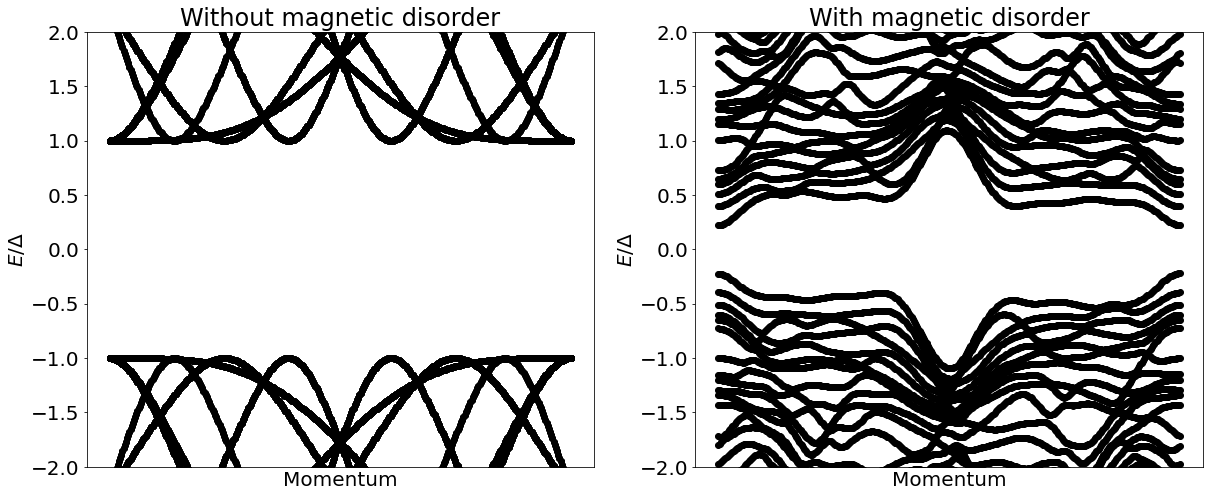

In [17]:
from pyqula import geometry, potentials
g = geometry.triangular_lattice() # take a triangular lattice
g = g.get_supercell((6,6)) # make a supercell so that we have many sites per unit cell
h = g.get_hamiltonian() # generate Hamiltonian

delta = 0.5 # superconducting order parameter
h.add_swave(delta) # add superconductivity

# first without magnetic disorder
plt.subplot(1,2,1) ; plt.title("Without magnetic disorder")
(k,e) = h.get_bands() # compute bands
plt.scatter(k,e/delta,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("$E/\Delta$") 
plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

# now with the magnetic disorder
plt.subplot(1,2,2) ; plt.title("With magnetic disorder")
fimp = potentials.impurity(g.r[0],v=[0.,0.,2.]) # magnetic impurity
h.add_exchange(lambda r: 2*delta*(np.random.random(3)-0.5)) # add local magnetic disorder
#h.add_onsite(lambda r: 2*delta*(np.random.random()-0.5)) # add local disorder
(k,e) = h.get_bands() # compute bands
plt.scatter(k,e/delta,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("$E/\Delta$") 
plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

### Exercise
- Change the strength of the magnetic disorder. How does the in-gap band change?
- Replace the magnetic disorder by non-magnetic disorder (add_onsite). Discuss why the result is different from the magnetic disorder

## Non-magnetic disorder in an unconventional superconductor
Let us now add random non-magnetic disorder to an unconventional superconductor, and see how that impact the superconducting gap

0.13474566025137838


(-2.0, 2.0)

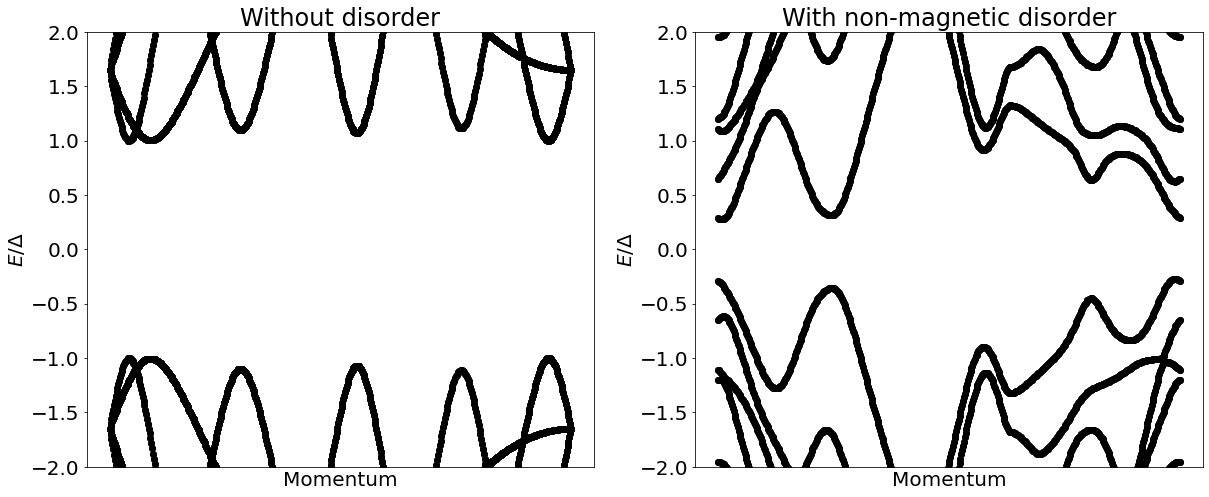

In [18]:
from pyqula import potentials, geometry
g = geometry.triangular_lattice() # take a triangular lattice
h = g.get_hamiltonian() # generate Hamiltonian
h.add_onsite(-3.0) # shift chemical potential 
delta = .1 # superconducting order parameter
h.add_pairing(delta=delta,mode="chiral_dwave") # add an unconventional order parameter
h = h.get_supercell(8) # make a supercell

# first without disorder
plt.subplot(1,2,1) ; plt.title("Without disorder")
gap = h.get_gap()/2. ; print(gap)
kpath=["G","K","M","G"]
(k,e) = h.get_bands(kpath=kpath) # compute bands
plt.scatter(k,e/gap,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("$E/\Delta$") 
plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

# now with the non-magnetic disorder
plt.subplot(1,2,2) ; plt.title("With non-magnetic disorder")
fimp = potentials.impurity(g.r[0],v=[0.,0.,2.]) # magnetic impurity
#h.add_exchange(lambda r: 2*delta*(np.random.random(3)-0.5)) # add local magnetic disorder
h.add_onsite(lambda r: 20*delta*(np.random.random()-0.5)) # add local disorder
(k,e) = h.get_bands(kpath=kpath) # compute bands
plt.scatter(k,e/gap,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("$E/\Delta$") 
plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

### Exercise
- Change the strength of the non-magnetic disorder. How does the in-gap states change?
- Discuss why a non-magnetic disorder decreases the gap of a fully gapped unconventional order parameter

# Artificial topological superconductivity
Here, as warm up exercise, we will create an artificial topological superconductor by combining s-wave superconductivity, exchange field and Rashba spin-orbit coupling. For the sake of concreteness we will use a triangular lattice with first neighbor hopping.

([], [])

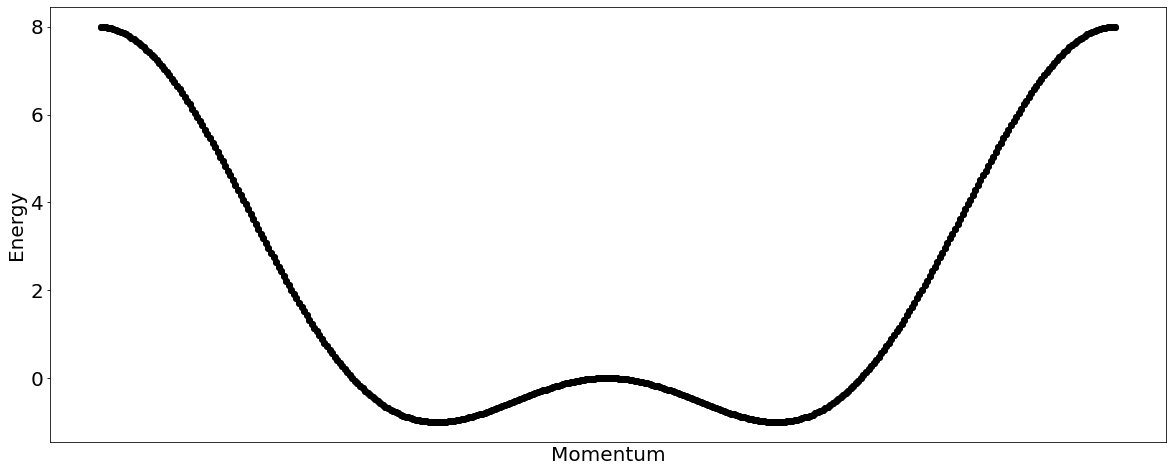

In [19]:
# Let us first look at the band structure without additional terms
from pyqula import geometry
g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_onsite(2.0) # shift chemical potential
(k,e) = h.get_bands() # compute the bands
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

([], [])

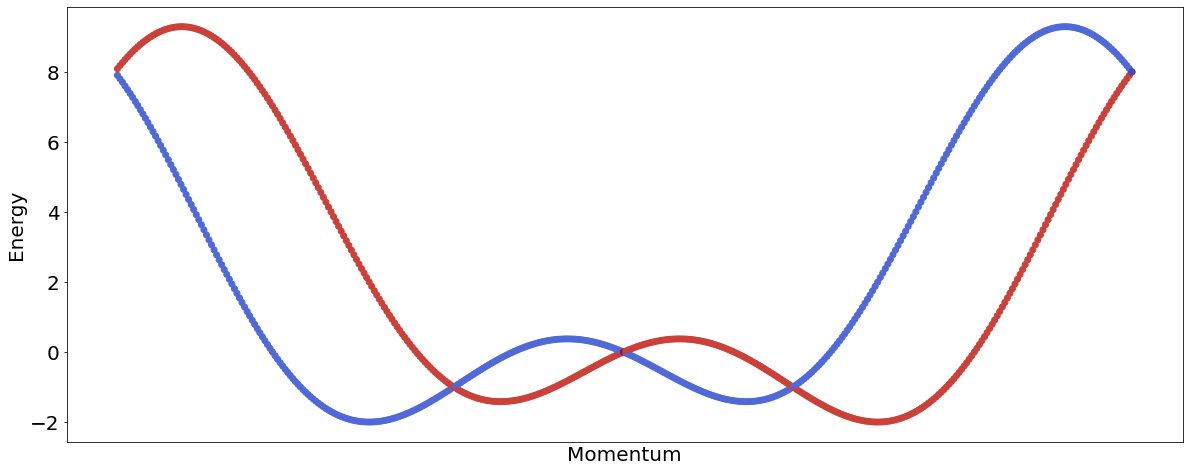

In [20]:
# Now we add Rashba spin-orbit coupling, to create a spin-momentum locking in the electronic structure
from pyqula import geometry
g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_rashba(1.0) # Rashba spin-orbit coupling
h.add_onsite(2.0) # shift chemical potential
(k,e,c) = h.get_bands(operator="sx") # compute the bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

### Exercise
- Decrease value of the Rashba SOC. Does the splitting in momentum space become bigger or smaller?

(-2.0, 2.0)

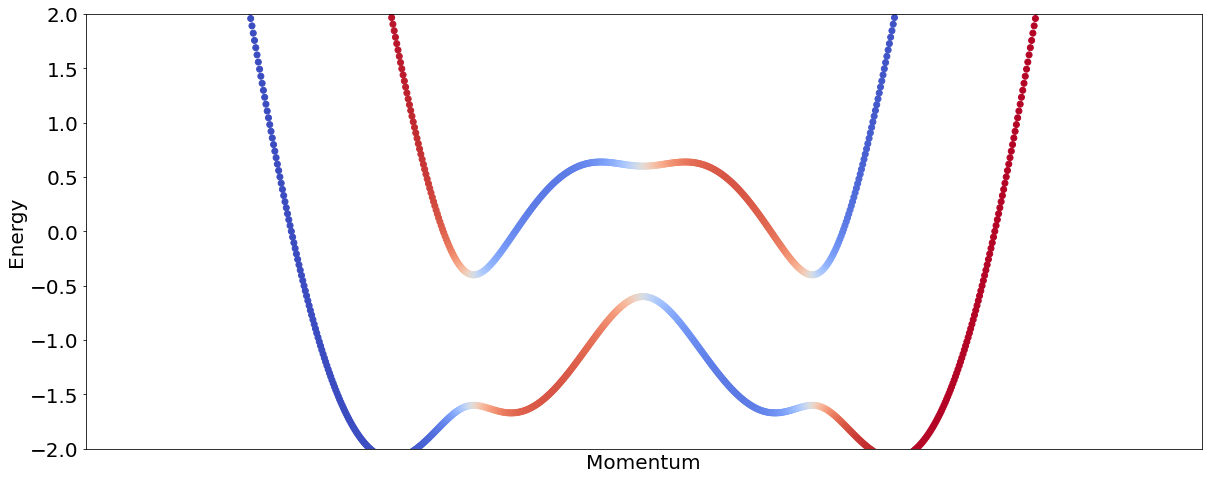

In [21]:
# Now we also add a Zeeman field, to open up a gap in the points where different spins cross
from pyqula import geometry
g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_rashba(1.0) # Rashba spin-orbit coupling
h.add_onsite(2.0) # shift chemical potential
h.add_zeeman([0.,0.,0.6]) # Zeeman field
(k,e,c) = h.get_bands(operator="sx",nk=800) # compute the bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-2.,2.]) # plot

### Exercise
- Discuss why an out-of plane field opens a gap in some of the previous crossings of the band structure
- Decrease value of the exchange field. Do the anticrossings become bigger or smaller?

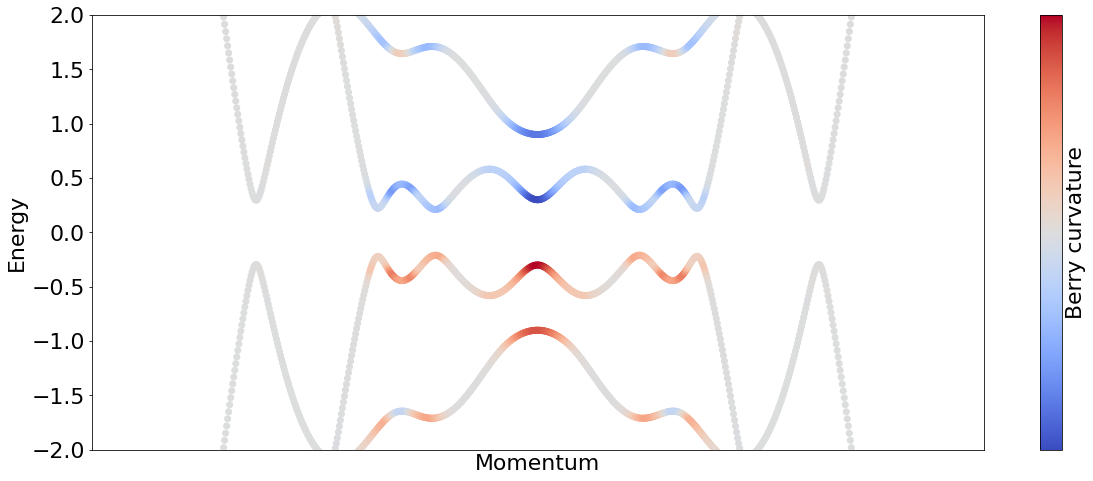

In [32]:
# finally we also add a superconducting order
from pyqula import geometry
g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_rashba(1.0) # Rashba spin-orbit coupling
h.add_onsite(2.0) # shift chemical potential
h.add_zeeman([0.,0.,0.6]) # Zeeman field
h.add_swave(.3) # add superconductivity
(k,e,c) = h.get_bands(operator="berry",nk=800) # compute the bands
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-2.,2.]) # plot
plt.colorbar(label="Berry curvature",ticks=[])

(-0.5, 59.5, 59.5, -0.5)

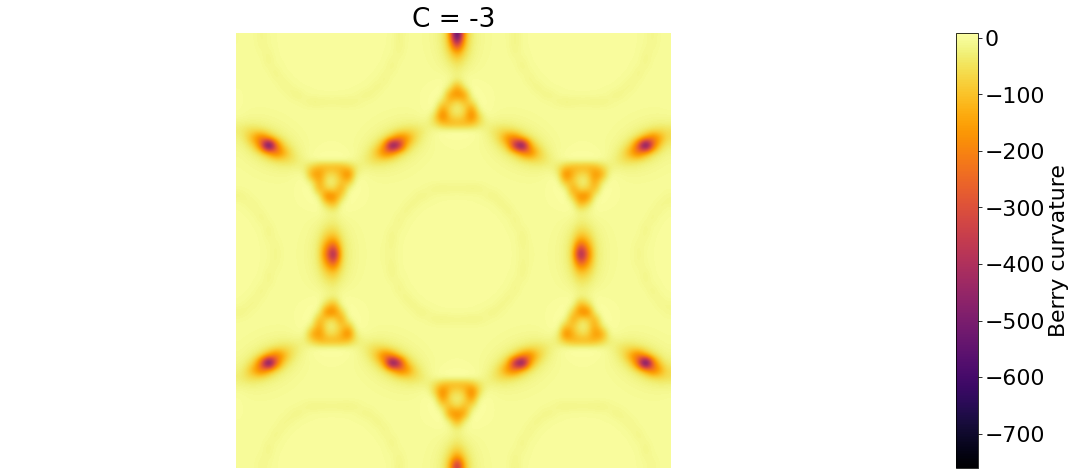

In [14]:
# Now let us compute the Chern number
from pyqula import geometry
g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_rashba(1.0) # Rashba spin-orbit coupling
h.add_onsite(2.0) # shift chemical potential
h.add_zeeman([0.,0.,0.6]) # Zeeman field
h.add_swave(.3) # add superconductivity
nk = 60 # number of kpoints
c = h.get_chern(nk=nk) # compute Chern number
# now let us compute the Berry curvature in 2D
(kx,ky,omega) = h.get_berry_curvature(nk=nk) # compute Berry curvature
plt.title("C = "+str(int(round(c))))
omega2d = np.array(omega).reshape((nk,nk)) # reshape as a 2d array
plt.imshow(omega2d,interpolation="bicubic",cmap="inferno") # plot
plt.axis("equal") ; plt.colorbar(label="Berry curvature") ; plt.axis("off") 

### Exercise
- Discuss what can be the consequence of having a Chern number
- If you change the chemical potential, do you still get a finite Chern number? Discuss why

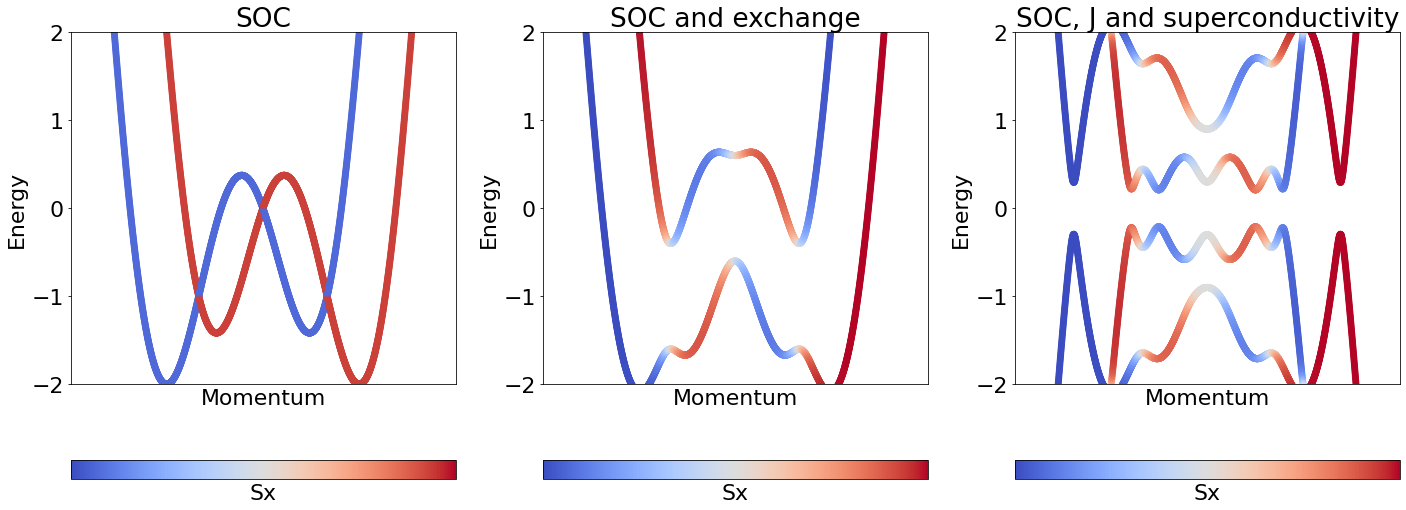

In [36]:
# let us now look at the three bands at the same time
from pyqula import geometry

def plot_case(h):
    (k,e,c) = h.get_bands(operator="sx",nk=2000) # compute the bands
    plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
    plt.xticks([]) ; plt.ylim([-2.,2.]) ; plt.xlim([min(k),max(k)])
    plt.colorbar(label="Sx",ticks=[],orientation="horizontal")


g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_onsite(2.0) # shift chemical potential

plt.subplot(1,3,1) ; plt.title("SOC")
h.add_rashba(1.0) # Rashba spin-orbit coupling
plot_case(h) # plot this case

plt.subplot(1,3,2) ; plt.title("SOC and exchange")
h.add_zeeman([0.,0.,0.6]) # Zeeman field
plot_case(h) # plot this case

plt.subplot(1,3,3) ; plt.title("SOC, J and superconductivity")
h.add_swave(.3) # add superconductivity
plot_case(h) # plot this case



plt.tight_layout()

## Edge states of an artificial topological superconductor
Here, taking as starting point the Hamiltonian of a topological superconductor above, we will show how topological edge states appear in finite systems

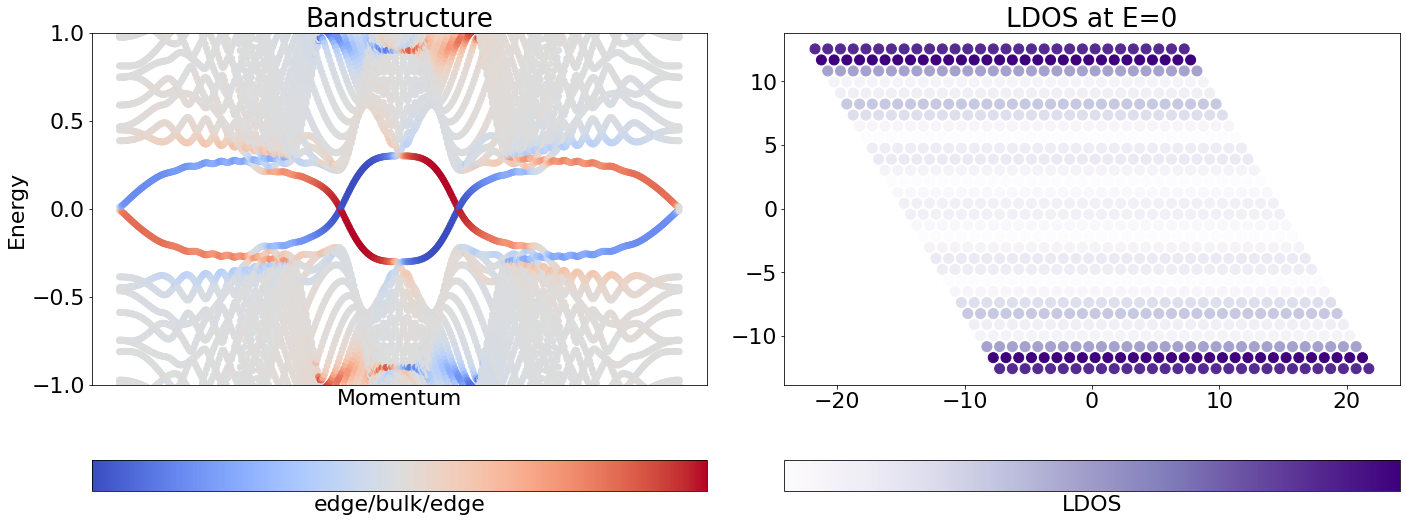

In [38]:
from pyqula import ribbon,geometry
g = geometry.triangular_lattice() # get the geometry
h = g.get_hamiltonian() # get the Hamiltonian
h.add_rashba(1.0) # Rashba spin-orbit coupling
h.add_onsite(2.0) # shift chemical potential
h.add_zeeman([0.,0.,0.6]) # Zeeman field
h.add_swave(.3) # add superconductivity

plt.subplot(1,2,1) ; plt.title("Bandstructure") # first the bands
hr = ribbon.bulk2ribbon(h,n=30) # create a ribbon from a bulk Hamiltonian
(k,e,c) = hr.get_bands(operator="yposition") # plot the bands highlighting the position
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-1.,1.])
plt.colorbar(label="edge/bulk/edge",ticks=[],orientation="horizontal")

plt.subplot(1,2,2) ; plt.title("LDOS at E=0") # now the LDOS
(x,y,d) = hr.get_ldos(energy=0.0,nrep=30,delta=1e-2,nk=50) # compute the local density of states
plt.scatter(x,y,c=d,s=100,cmap="Purples") ; plt.axis("equal") 
plt.colorbar(label="LDOS",ticks=[],orientation="horizontal")

plt.tight_layout() # adjust subplots

### Exercise
- The localization of the edge modes depends on the topological gap. Show that for parameters yielding a small topological gap, the edge states are more delocalized
- Show that if the ribbon is not wide enough, the edge states hybridize and lead to a gap opening

#### In the lab
- Topological superconductivity has been observed in artificial NbSe2/CrBr3 heterostructures
https://www.nature.com/articles/s41586-020-2989-y

## Topological phase transition with the exchange field
Above we saw that superconductivity can coexist with spin-orbit coupling. Since the superconductor at zero exchange field is trivial, a topological phase transition must occur as the exchange field is turned on. Here we will show how such a phase transition takes place

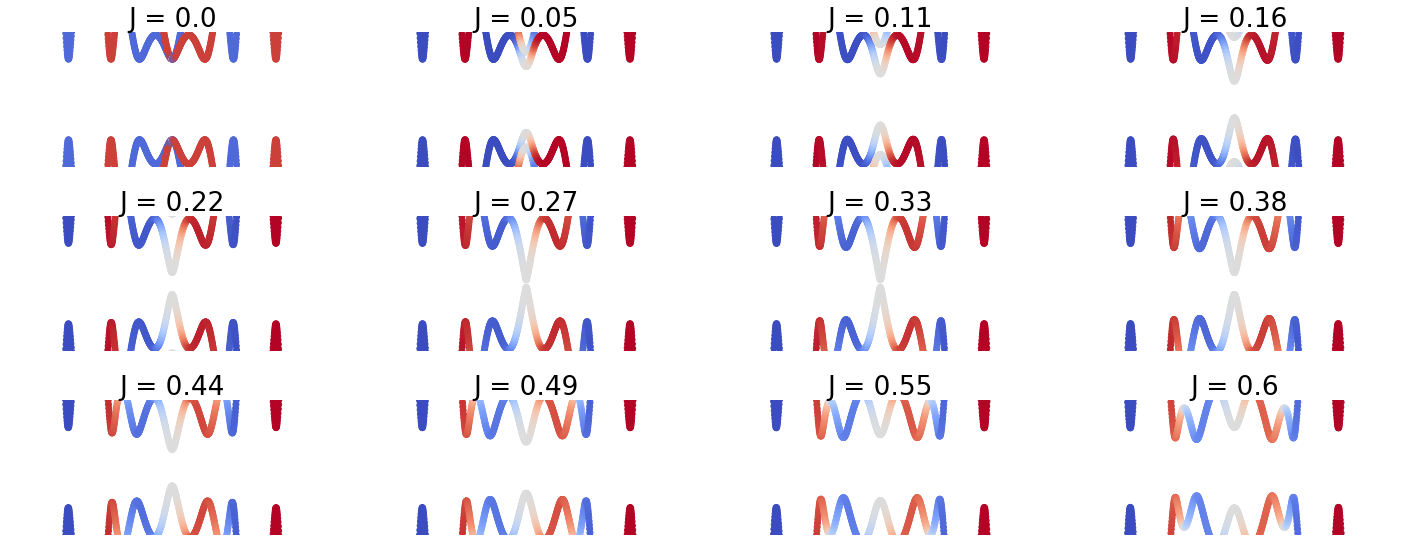

In [39]:
# plot the bands for different exchance couplings
from pyqula import geometry
Js = np.linspace(0.,0.6,12) # exchange couplings
ij = 0 # counter
for J in Js: # loop over exchange couplings
    g = geometry.triangular_lattice() # get the geometry
    h = g.get_hamiltonian() # get the Hamiltonian
    h.add_onsite(2.0) # shift chemical potential
    h.add_rashba(1.0) # add Rashba SOC
    h.add_zeeman([0.,0.,J]) # add exchange field
    h.add_swave(0.3) # add swave SC
    (k,e,c) = h.get_bands(nk=1000,operator="sx") # compute the bands
    plt.subplot(len(Js)//4,4,ij+1) ; ij +=1 
    plt.scatter(k,e,c=c) ; plt.axis("off") ; plt.ylim([-0.5,0.5]) ; plt.title("J = "+str(round(J,2))) # plot

plt.tight_layout() # adjust subplots

### Exercise
- See if you can create such a topological phase transition with an in-plane exchange field. 
- Why is an out of plane exchange field required? 
- Discuss with your colleagues if there is some symmetry reason why an in-plane exchange field does not work